In [11]:
%pip install kuramoto networkx matplotlib imageio-ffmpeg


   ---------------------------------------- 0.0/31.2 MB ? eta -:--:--
    --------------------------------------- 0.5/31.2 MB 4.2 MB/s eta 0:00:08
   -- ------------------------------------- 1.8/31.2 MB 5.9 MB/s eta 0:00:05
   ---- ----------------------------------- 3.4/31.2 MB 6.5 MB/s eta 0:00:05
   ------ --------------------------------- 5.0/31.2 MB 6.9 MB/s eta 0:00:04
   ------- -------------------------------- 5.8/31.2 MB 6.6 MB/s eta 0:00:04
   -------- ------------------------------- 6.3/31.2 MB 5.6 MB/s eta 0:00:05
   --------- ------------------------------ 7.6/31.2 MB 5.6 MB/s eta 0:00:05
   ----------- ---------------------------- 8.7/31.2 MB 5.5 MB/s eta 0:00:05
   ------------ --------------------------- 9.7/31.2 MB 5.5 MB/s eta 0:00:04
   -------------- ------------------------- 11.0/31.2 MB 5.6 MB/s eta 0:00:04
   --------------- ------------------------ 12.1/31.2 MB 5.6 MB/s eta 0:00:04
   ---------------- ----------------------- 12.8/31.2 MB 5.4 MB/s eta 0:00:04
   

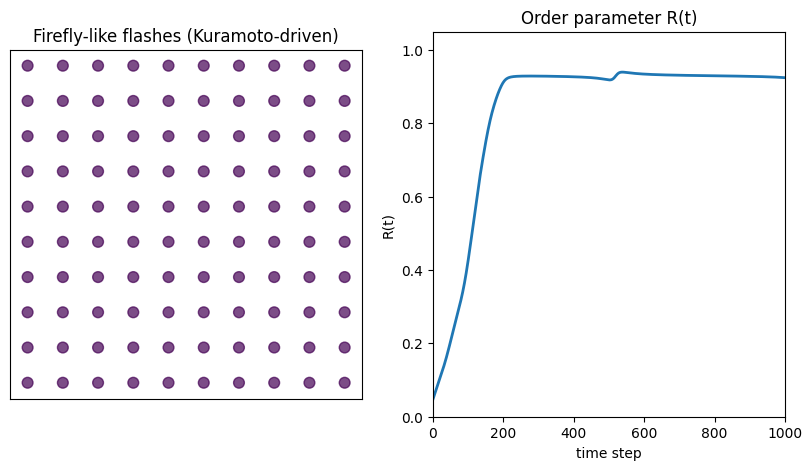

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
from kuramoto import Kuramoto

# --------- 模擬參數 ----------
N_side = 10
N = N_side * N_side        # 總螢火蟲數
K = 3.0                    # 耦合強度（大一點更容易同步）
dt = 0.02                  # 時間步長
T = 20                     # 總時長（秒）
# ----------------------------

# 全連線（類比同一群螢火蟲互見）
G = nx.erdos_renyi_graph(n=N, p=1.0)
A = nx.to_numpy_array(G)

# 建模與模擬
model = Kuramoto(coupling=K, dt=dt, T=T, n_nodes=N)
# 可選：給定自然頻率分佈（預設會自動設定）
# model.natfreqs = np.random.normal(1.0, 0.1, size=N)
theta_ts = model.run(adj_mat=A)    # shape: (N, time_steps)
time_steps = theta_ts.shape[1]

# 把相位包到 [0, 2pi)
theta_ts = np.mod(theta_ts, 2*np.pi)

# 閃爍偵測：相位從接近 2π 跳到小值 -> 記作閃爍
flashes = np.zeros_like(theta_ts, dtype=bool)
eps = 1.0  # 閾值，可微調
flashes[:,1:] = (theta_ts[:,1:] < eps) & (theta_ts[:,:-1] > (2*np.pi - eps))

# 2D 位置（點陣）
xs, ys = np.meshgrid(np.arange(N_side), np.arange(N_side))
pos = np.c_[xs.ravel(), ys.ravel()]

# 計算同步指標 R_t（也可用套件的 phase_coherence）
def order_param(phases):
    z = np.exp(1j*phases)
    R = np.abs(np.mean(z))
    return R

R_t = np.array([order_param(theta_ts[:,t]) for t in range(time_steps)])

# --------- 視覺化 ---------
fig = plt.figure(figsize=(10,5))
ax_scatter = plt.subplot(1,2,1)
ax_R = plt.subplot(1,2,2)

# 左：點陣動畫
sc = ax_scatter.scatter(pos[:,0], pos[:,1], s=60, alpha=0.7)
ax_scatter.set_title("Firefly-like flashes (Kuramoto-driven)")
ax_scatter.set_aspect('equal')
ax_scatter.set_xticks([])
ax_scatter.set_yticks([])
ax_scatter.set_xlim(-0.5, N_side-0.5)
ax_scatter.set_height = N_side-0.5

# 右：同步指標曲線（隨時間更新）
line_R, = ax_R.plot([], [], lw=2)
ax_R.set_xlim(0, time_steps)
ax_R.set_ylim(0, 1.05)
ax_R.set_xlabel("time step")
ax_R.set_ylabel("R(t)")
ax_R.set_title("Order parameter R(t)")

def init():
    sc.set_array(None)
    line_R.set_data([], [])
    return sc, line_R

def update(frame):
    # 讓當前閃爍的點顯示高亮（用顏色編碼）
    colors = np.where(flashes[:, frame], 1.0, 0.1)  # 亮=1.0, 暗=0.1
    sc.set_array(colors)

    # 更新 R(t) 曲線至目前步
    line_R.set_data(np.arange(frame+1), R_t[:frame+1])
    return sc, line_R

ani = FuncAnimation(fig, update, frames=time_steps, init_func=init, interval=30, blit=True)
# 儲存 MP4 或 GIF（擇一）
# ani.save("fireflies_kuramoto.mp4", fps=30)
ani.save("fireflies_kuramoto.gif", fps=30, writer="pillow")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from pathlib import Path

# ---------------- CONFIG ----------------
N = 100                 # number of flies
K = 2.2                 # coupling strength
omega0 = 1.0            # mean natural frequency
omega_std = 0.15        # std of natural frequency
dt = 0.3               # time step (seconds)
T = 120.0               # total simulation time (seconds)
flash_eps = 1         # threshold near 0 for "flash"
seed = 7                # RNG seed
fps = 30                # animation frames per second
canvas_size = (6, 6)    # figure size in inches
outfile = Path("fireflies_kuramoto_random.mp4")  # output file
# -----------------------------------------

# Random setup
rng = np.random.default_rng(seed)
xy = rng.random((N, 2))  # random positions in [0,1]x[0,1]
omega = rng.normal(omega0, omega_std, size=N)  # natural frequencies
steps = int(T / dt)
frames = int(round(T * fps))  # ensure 1 second of video equals 1 second of sim time
theta = rng.uniform(0, 2*np.pi, size=N)  # initial phases

# Store flash events
flashes = np.zeros((steps, N), dtype=bool)

# Simulation loop (Euler integration)
for t in range(steps):
    order_vec = np.exp(1j * theta)
    mean_field = np.mean(order_vec)
    coupling_term = np.imag(np.exp(-1j * theta) * mean_field) * K
    dtheta = omega + coupling_term
    theta_new = theta + dt * dtheta
    theta_wrapped = np.mod(theta_new, 2*np.pi)
    just_wrapped = (theta_wrapped < flash_eps) & (theta > (2*np.pi - flash_eps))
    flashes[t] = just_wrapped
    theta = theta_wrapped

# Plot setup
fig, ax = plt.subplots(figsize=canvas_size)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Fireflies (Kuramoto-driven): random scatter & flashes")

base_size = 20
flash_size = 120
sc = ax.scatter(xy[:,0], xy[:,1], s=base_size, alpha=0.35)

# Sync message text (initially empty) and persistent flag
sync_text = ax.text(
    0.5, 1.02, "",
    transform=ax.transAxes,
    ha="center", va="bottom",
    fontsize=14, color="crimson", fontweight="bold"
)
synced = [False]

# Animation update function
def update(frame):
    # map animation frame -> simulation index to keep real-time mapping
    t_idx = int(round(frame * (steps - 1) / (frames - 1))) if frames > 1 else 0

    f = flashes[t_idx]
    f_prev = flashes[t_idx-1] if t_idx > 0 else np.zeros_like(f)
    flash_now = f | f_prev  # keep flash for 2 frames for visibility
    sizes = np.where(flash_now, flash_size, base_size)
    alphas = np.where(flash_now, 1.0, 0.35)

    sc.set_sizes(sizes)
    fc = sc.get_facecolors()
    if fc.shape[0] == N:
        fc[:, 3] = alphas  # set per-point alpha
        sc.set_facecolors(fc)

    # Persist message after the first fully synchronized flash
    if (not synced[0]) and np.all(f):
        synced[0] = True
    sync_text.set_text("SYNCHRONIZED!" if synced[0] else "")

    ax.set_xlabel(f"time = {t_idx*dt:0.2f}s")
    return (sc,)

# Create and save animation
# Try to locate ffmpeg via imageio-ffmpeg if available
import matplotlib as mpl
try:
    import imageio_ffmpeg as iioff
    mpl.rcParams['animation.ffmpeg_path'] = iioff.get_ffmpeg_exe()
except Exception:
    pass

anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
try:
    writer = FFMpegWriter(fps=fps, codec="libx264", bitrate=1800, extra_args=["-pix_fmt", "yuv420p"])  # MP4 writer
    anim.save(outfile, writer=writer)
    print(f"Saved MP4 to: {outfile}")
except (FileNotFoundError, RuntimeError):
    print("FFmpeg not found. Install with: conda install -c conda-forge ffmpeg  OR  pip install imageio-ffmpeg")
    raise
finally:
    plt.close(fig)


Saved GIF to: fireflies_kuramoto_random.gif


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from pathlib import Path

# ---------------- CONFIG ----------------
N = 100                 # number of flies
K = 2.2                 # coupling strength
omega0 = 4.0            # mean natural frequency
omega_std = 0.15        # std of natural frequency
dt = 0.03               # time step (seconds)
T = 120.0               # total simulation time (seconds)
flash_eps = 1         # threshold near 0 for "flash"
seed = 7                # RNG seed
fps = 30                # animation frames per second
canvas_size = (6, 6)    # figure size in inches
outfile = Path("fireflies_kuramoto_random_new.mp4")  # output file
# -----------------------------------------

# Random setup
rng = np.random.default_rng(seed)
xy = rng.random((N, 2))  # random positions in [0,1]x[0,1]
omega = rng.normal(omega0, omega_std, size=N)  # natural frequencies
steps = int(T / dt)
frames = int(round(T * fps))  # ensure 1 second of video equals 1 second of sim time
theta = rng.uniform(0, 2*np.pi, size=N)  # initial phases

# Store flash events
flashes = np.zeros((steps, N), dtype=bool)

# Simulation loop (Euler integration)
for t in range(steps):
    order_vec = np.exp(1j * theta)
    mean_field = np.mean(order_vec)
    coupling_term = np.imag(np.exp(-1j * theta) * mean_field) * K
    dtheta = omega + coupling_term
    theta_new = theta + dt * dtheta
    theta_wrapped = np.mod(theta_new, 2*np.pi)
    just_wrapped = (theta_wrapped < flash_eps) & (theta > (2*np.pi - flash_eps))
    flashes[t] = just_wrapped
    theta = theta_wrapped

# Plot setup
fig, ax = plt.subplots(figsize=canvas_size)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Fireflies (Kuramoto-driven): random scatter & flashes")

base_size = 20
flash_size = 120
sc = ax.scatter(xy[:,0], xy[:,1], s=base_size, alpha=0.35)

# Sync message text (initially empty) and persistent flag
sync_text = ax.text(
    0.5, 1.02, "",
    transform=ax.transAxes,
    ha="center", va="bottom",
    fontsize=14, color="crimson", fontweight="bold"
)
synced = [False]

# Animation update function
def update(frame):
    # map animation frame -> simulation index to keep real-time mapping
    t_idx = int(round(frame * (steps - 1) / (frames - 1))) if frames > 1 else 0

    f = flashes[t_idx]
    f_prev = flashes[t_idx-1] if t_idx > 0 else np.zeros_like(f)
    flash_now = f | f_prev  # keep flash for 2 frames for visibility
    sizes = np.where(flash_now, flash_size, base_size)
    alphas = np.where(flash_now, 1.0, 0.35)

    sc.set_sizes(sizes)
    fc = sc.get_facecolors()
    if fc.shape[0] == N:
        fc[:, 3] = alphas  # set per-point alpha
        sc.set_facecolors(fc)

    # Persist message after the first fully synchronized flash
    if (not synced[0]) and np.all(f):
        synced[0] = True
    sync_text.set_text("SYNCHRONIZED!" if synced[0] else "")

    ax.set_xlabel(f"time = {t_idx*dt:0.2f}s")
    return (sc,)

# Create and save animation
# Try to locate ffmpeg via imageio-ffmpeg if available
import matplotlib as mpl
try:
    import imageio_ffmpeg as iioff
    mpl.rcParams['animation.ffmpeg_path'] = iioff.get_ffmpeg_exe()
except Exception:
    pass

anim = FuncAnimation(fig, update, frames=frames, interval=1000/fps, blit=False)
try:
    writer = FFMpegWriter(fps=fps, codec="libx264", bitrate=1800, extra_args=["-pix_fmt", "yuv420p"])  # MP4 writer
    anim.save(outfile, writer=writer)
    print(f"Saved MP4 to: {outfile}")
except (FileNotFoundError, RuntimeError):
    print("FFmpeg not found. Install with: conda install -c conda-forge ffmpeg  OR  pip install imageio-ffmpeg")
    raise
finally:
    plt.close(fig)


Saved MP4 to: fireflies_kuramoto_random_new.mp4


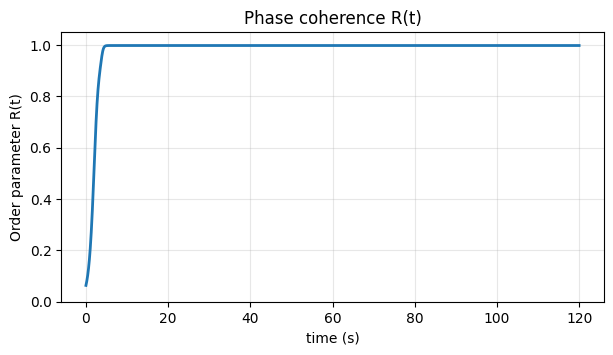

In [18]:
# Plot order parameter R(t) vs time for a random-scatter Kuramoto simulation
import numpy as np
import matplotlib.pyplot as plt

# Use existing globals if available; otherwise fallback to defaults
# N = globals().get('N', 100)
# K = globals().get('K', 2.2)
# omega0 = globals().get('omega0', 4.0)
# omega_std = globals().get('omega_std', 0.15)
# dt = globals().get('dt', 0.3)
# T = globals().get('T', 120.0)
# seed = globals().get('seed', 7)

# Setup
rng = np.random.default_rng(seed)
omega = rng.normal(omega0, omega_std, size=N)
steps = int(T / dt)

theta = rng.uniform(0, 2*np.pi, size=N)
R_t = np.zeros(steps)

# Simulation + order parameter tracking
for t in range(steps):
    z = np.exp(1j * theta)
    R_t[t] = np.abs(np.mean(z))

    mean_field = np.mean(z)
    coupling_term = np.imag(np.exp(-1j * theta) * mean_field) * K
    dtheta = omega + coupling_term
    theta = np.mod(theta + dt * dtheta, 2*np.pi)

# Time axis
time = np.arange(steps) * dt

# Plot
fig, ax = plt.subplots(figsize=(7, 3.5))
ax.plot(time, R_t, lw=2)
ax.set_xlabel('time (s)')
ax.set_ylabel('Order parameter R(t)')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.set_title('Phase coherence R(t)')
plt.show()


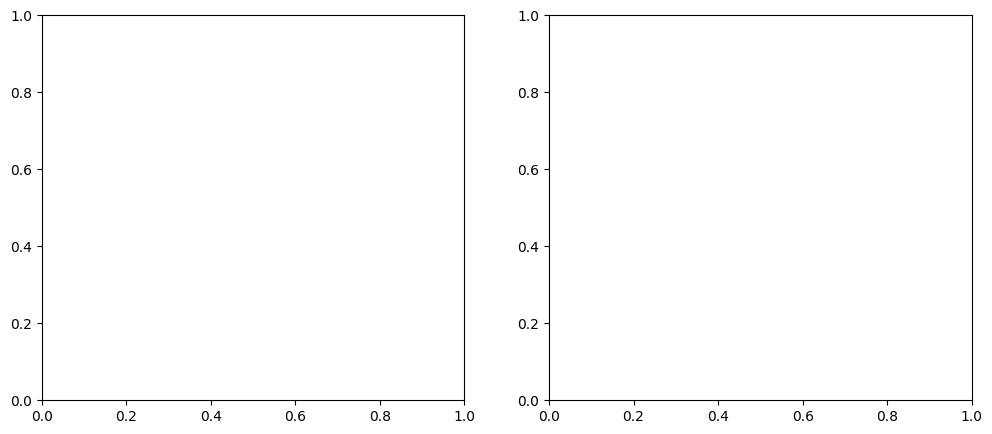